<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/ResNet50V2-severe/vecicle_damage_ResNet50V2_epoch_20_severity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1150 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Epoch 1/10
71/71 [==============================] - 36s 460ms/step - loss: 1.3463 - accuracy: 0.3263 - val_loss: 1.2614 - val_accuracy: 0.3973
Epoch 2/10
71/71 [==============================] - 20s 285ms/step - loss: 1.1338 - accuracy: 0.4180 - val_loss: 1.1202 - val_accuracy: 0.4732
Epoch 3/10
71/71 [==============================] - 22s 307ms/step - loss: 1.0037 - accuracy: 0.4877 - val_loss: 1.0318 - val_accuracy: 0.5312
Epoch 4/10
71/71 [==============================] - 22s 307ms/step - loss: 0.9296 - accuracy: 0.5397 - val_loss: 0.9914 - val_accuracy: 0.5536
Epoch 5/10
71/71 [==============================] - 22s 307ms/step - loss: 0.9077 - accuracy: 0.5794 - val_loss: 0.9647 - val_accuracy: 0.5714
Epoch 6/10
71/71 [==============================] - 23s 328ms/step - loss: 0.8770 - accuracy: 0.5714 - val_loss: 0.9320 - val_accuracy: 0.5982
Epoch 7/10
71/71 [

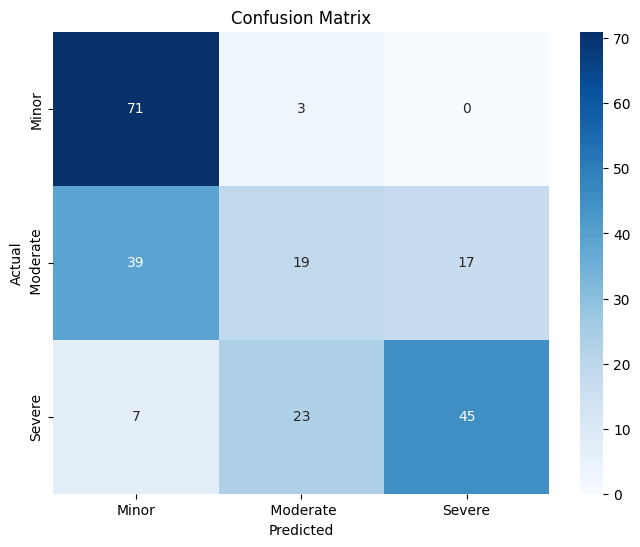

Test loss: 0.9359
Test accuracy: 60.71
Train loss: 0.7705
Train accuracy: 64.26
Recall: 0.60
Precision: 0.58
F1-score: 0.57


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/new datasets severe/train'
val_dir = '/content/drive/MyDrive/new datasets severe/validation'
test_dir = '/content/drive/MyDrive/new datasets severe/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16

# Create data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a dense layer for classification
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(3, activation='softmax')(x)  # Assuming 2 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', ' Moderate', 'Severe'], yticklabels=['Minor', ' Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_ResNet50V2_epoch_20_severity_changed_learning_rate_dataset.h5')
